<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/master/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!python setup.py develop

Cloning into 'ExoRIM'...
remote: Enumerating objects: 1552, done.
remote: Counting objects: 100% (1552/1552), done.
remote: Compressing objects: 100% (490/490), done.
remote: Total 1552 (delta 1062), reused 1528 (delta 1041), pack-reused 0
Receiving objects: 100% (1552/1552), 27.85 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (1062/1062), done.
/content/ExoRIM
running develop
running egg_info
creating exorim.egg-info
writing exorim.egg-info/PKG-INFO
writing dependency_links to exorim.egg-info/dependency_links.txt
writing top-level names to exorim.egg-info/top_level.txt
writing manifest file 'exorim.egg-info/SOURCES.txt'
writing manifest file 'exorim.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/exorim.egg-link (link to .)
Adding exorim 0.9.0 to easy-install.pth file

Installed /content/ExoRIM
Processing dependencies for exorim==0.9.0
Finished processing dependencies for exorim==0.9.0


In [2]:
from exorim import RIM, PhysicalModel
from exorim.simulated_data import CenteredBinariesDataset 
from exorim.definitions import DTYPE, rad2mas
from exorim.physical_model import GOLAY9, JWST_NIRISS_MASK
from exorim.models.modelv2 import Model as Modelv2
from exorim.models.rim_unet_model import UnetModel


from argparse import ArgumentParser
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from glob import glob
import collections
import pickle
from IPython.display import HTML

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [34]:
parser = ArgumentParser()
parser.add_argument("--pixels", type=int, default=32, help="Size of the reconstructed image")
parser.add_argument("--log_floor", type=float, default=1e-3, help="Set the dynamic range of the model")
parser.add_argument("--wavelength", type=float, default=3.8e-6, help="Wavelength of the observed light in meters")
parser.add_argument("--oversampling_factor", type=float, default=2, help="How small to set plate scale relative to the Michelson criteria")
parser.add_argument("--amplitude_noise_std", type=float, default=1e-3)
parser.add_argument("--closure_phase_noise_std", type=float, default=1e-3)
parser.add_argument("--learning_rate", type=float, default=3e-4)
parser.add_argument("--decay_rate", type=float, default=1)
parser.add_argument("--decay_steps", type=int, default=50)
parser.add_argument("--total_items", type=int, default=10)
parser.add_argument("--split", type=float, default=0.8)
parser.add_argument("--batch_size", type=int, default=1, help="Batch size")
parser.add_argument("--max_epoch", type=int, default=30, help="Maximum number of epoch")
parser.add_argument("--seed", type=float, default=42, help="Dataset seed")

args, unknown = parser.parse_known_args()


phys = PhysicalModel( # GOLAY9 mask
    pixels=args.pixels,
    mask_coordinates=JWST_NIRISS_MASK,
    wavelength=args.wavelength,
    logim=True,
    oversampling_factor=args.oversampling_factor,
)


dataset = CenteredBinariesDataset(phys, total_items=args.total_items, batch_size=args.batch_size, width=2, seed=10)

model = Modelv2(
    filters=64,
    filter_scaling=2,
    kernel_size=3,
    layers=2,
    block_conv_layers=3,
    strides=2,
    activation="tanh"
)

rim = RIM(model, physical_model=phys, adam=True, time_steps=4, log_floor=args.log_floor)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps
)
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate_schedule)

amplitude_noise_std = tf.ones(shape=phys.A.shape[0]) * args.amplitude_noise_std
closure_phase_noise_std = tf.ones(shape=phys.CPO.shape[0]) * args.closure_phase_noise_std
noise_std = tf.concat([amplitude_noise_std, closure_phase_noise_std], axis=0)

metrics = {
    "Chi squared": lambda Y_pred, X_true: tf.reduce_mean(phys.chi_squared(Y_pred, phys.forward(X_true), noise_std))
}

start = time.time()
epoch = 1
history = {"train_loss": []}#, "test_loss": []}
history.update({key + "_train": [] for key in metrics.keys()})
# history.update({key + "_test": [] for key in metrics.keys()})
min_score = np.inf
epoch_loss = tf.metrics.Mean()
step = 1
max_epochs = args.max_epoch
max_time = 0.5
while  epoch < max_epochs and (time.time() - start) < max_time*3600:
    epoch_loss.reset_states()
    metrics_train = {key: 0 for key in metrics.keys()}
    batch = 0
    for (X, Y) in dataset:
        batch += 1
        with tf.GradientTape() as tape:
            tape.watch(rim.model.trainable_weights)
            output = rim.call(X, noise_std)
            cost_value = tf.reduce_sum((Y + rim.log_floor) / tf.reduce_sum((Y + rim.log_floor)) * (output - rim.link_function(Y))**2, axis=(1, 2, 3))
            cost_value = tf.reduce_mean(cost_value)
            # cost_value += tf.reduce_sum(rim.model.losses)  # Add layer specific regularizer losses (L2 in definitions)
        epoch_loss.update_state([cost_value])
        gradient = tape.gradient(cost_value, rim.model.trainable_weights)
        # gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optimizer.apply_gradients(zip(gradient, rim.model.trainable_weights))

        # back to image space for analysis
        output = rim.inverse_link_function(output)
        # ========= Summaries and logs =================
        for key, item in metrics_train.items():
            score = metrics[key](output[-1], Y)
            metrics_train[key] += score.numpy()
            tf.summary.scalar(key, score, step=step)
        step += 1
        # ================================================
    for key, item in metrics_train.items():
        history[key + "_train"].append(item/(batch + 1))
    history["train_loss"].append(epoch_loss.result().numpy())
    print(epoch_loss.result().numpy())
    epoch += 1


0.39241844
0.3522541
0.33318263
0.32314628
0.31156105
0.29601464
0.27746767
0.26178092
0.24952622
0.24466357
0.25172818
0.30420035
0.26316583
0.26490384
0.2297256
0.20567755
0.19561826
0.2265754
0.20258054
0.180962
0.1816975
0.2002987
0.20442972
0.20614275
0.2293971
0.18485713
0.16544622
0.14688402
0.17098436


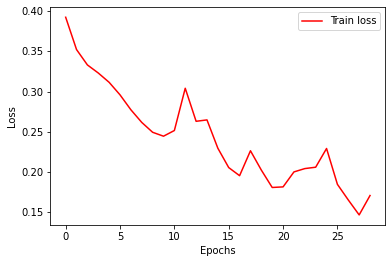

In [35]:
train_loss = history["train_loss"]
plt.figure()
plt.plot(train_loss, "-r", label="Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.yscale("log")

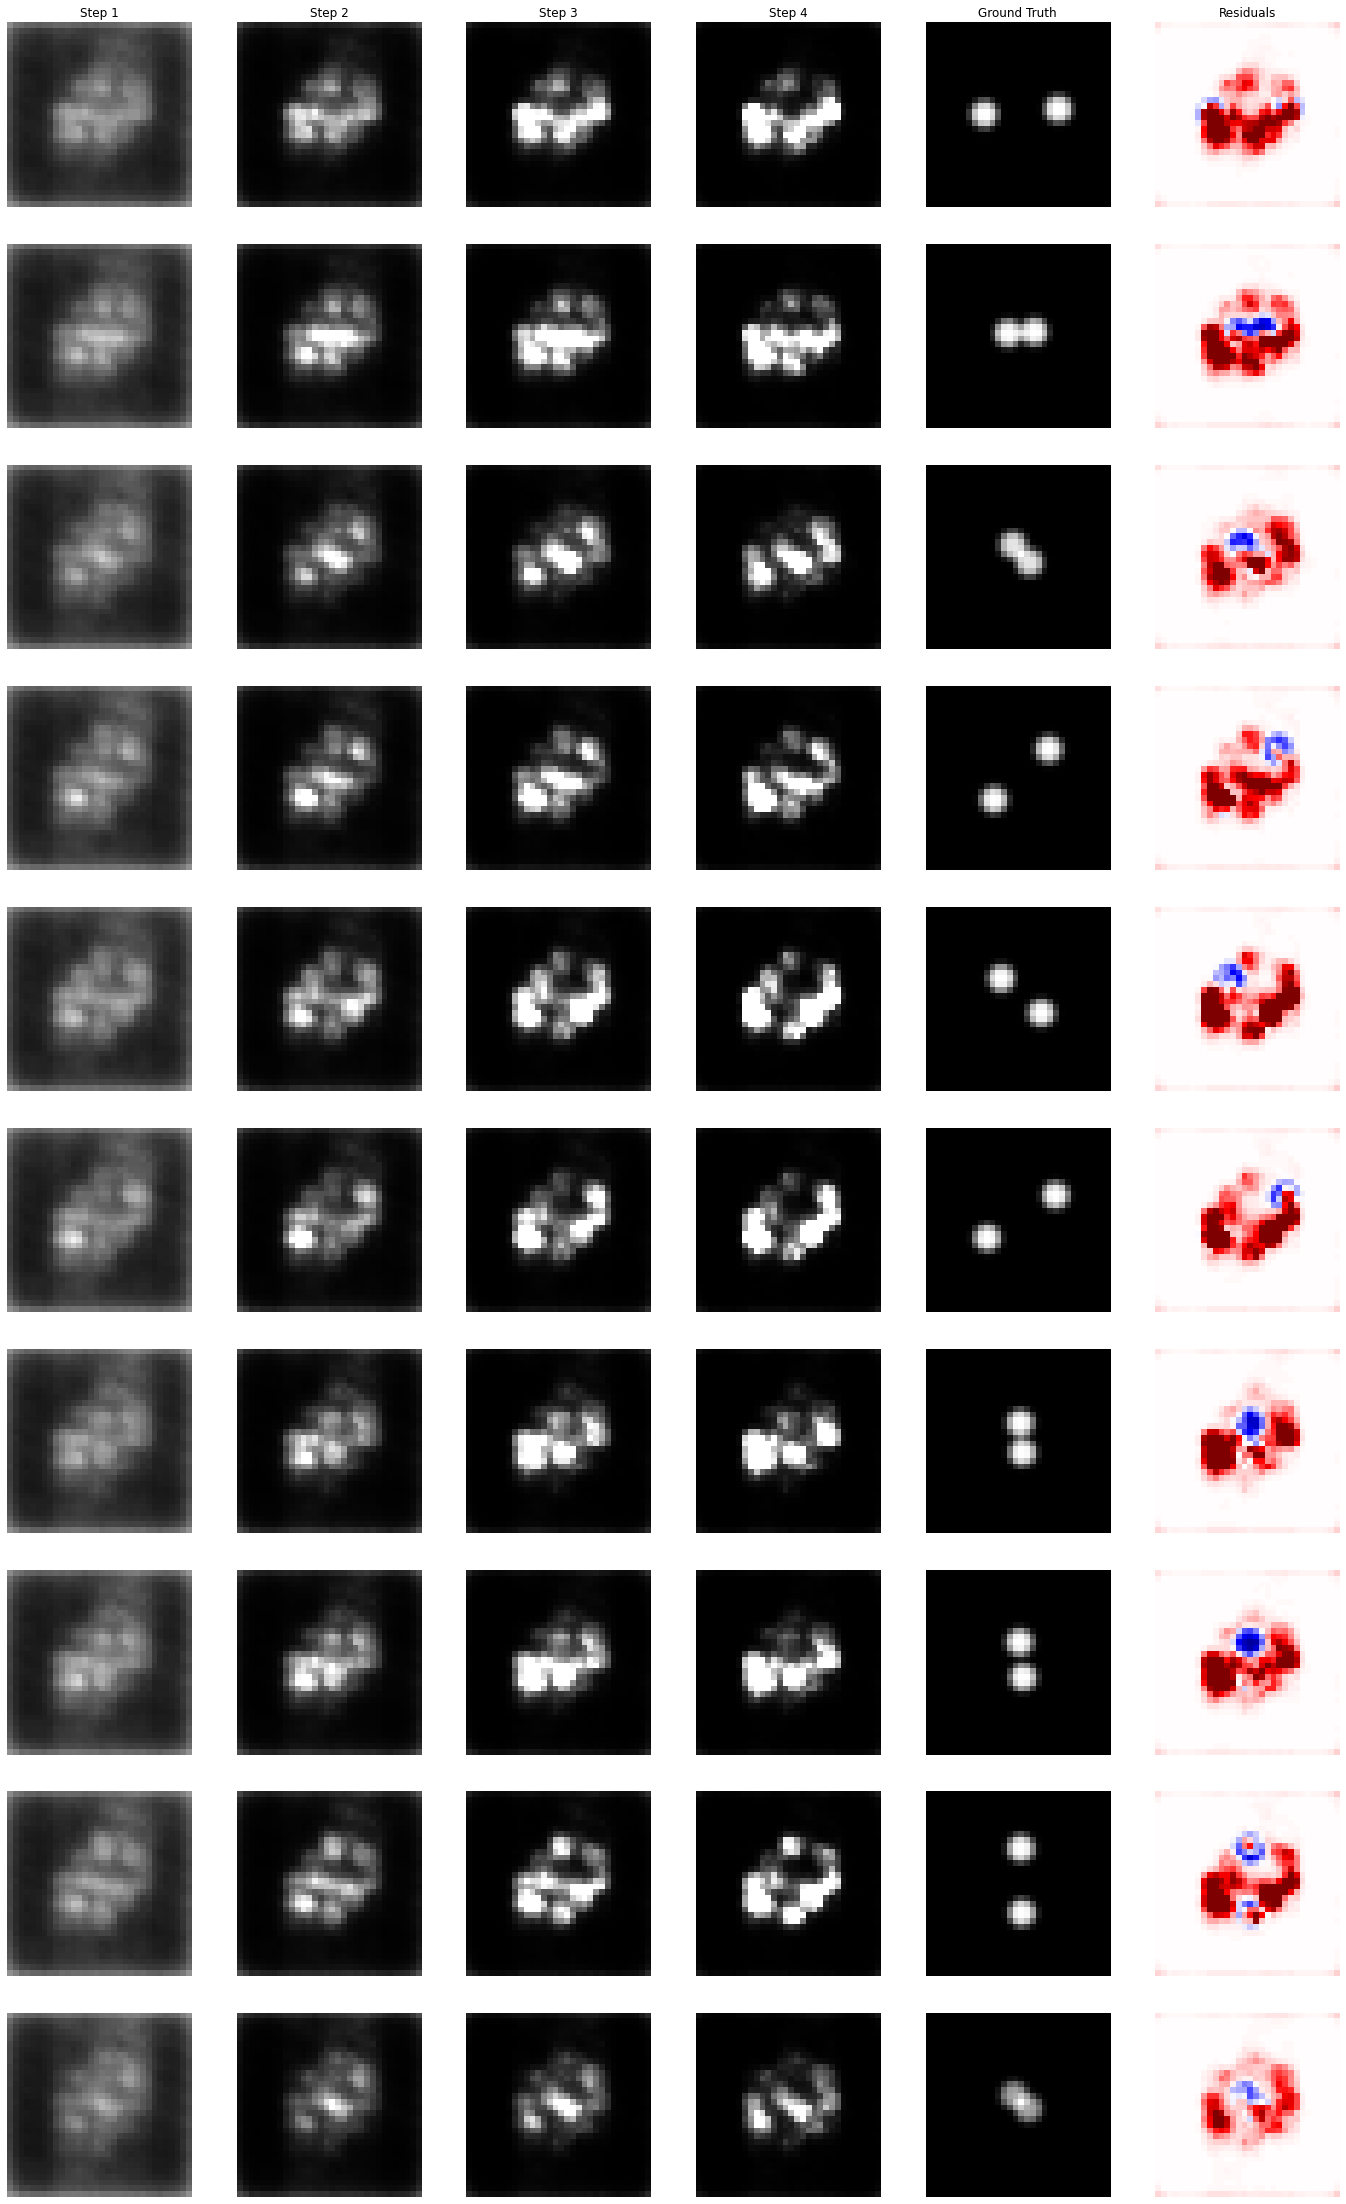

In [36]:
N = 10
fig,axs = plt.subplots(N, 6, figsize=(6*4, N*4))
# fig.suptitle("Image reconstruction process", fontsize=16)
for j in range(N):
    X, Y = dataset[j]
    out = rim.inverse_link_function(rim.call(X, noise_std))
    for i in range(4):
        axs[j, i].imshow(out[i, 0, ..., 0], cmap="gray", origin="lower", vmin=0, vmax=1)
        axs[j, i].axis("off")
        if j == 0:
            axs[j, i].set_title(f"Step {i+1}")

    axs[j, 4].imshow(Y[0, ..., 0], cmap="gray", origin="lower", vmin=0, vmax=1)
    axs[j, 4].axis("off")
    axs[j, 5].imshow(out[-1, 0, ..., 0] - Y[0, ..., 0], cmap="seismic", origin="lower", vmin=-1, vmax=1)
    axs[j, 5].axis("off")
    if j == 0:
        axs[j, 4].set_title(f"Ground Truth")
        axs[j, 5].set_title(f"Residuals")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'UV coverage')

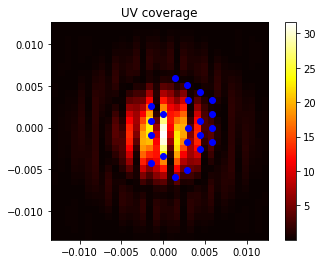

In [37]:
X, Y = dataset[0]
fft = np.abs(np.fft.fftshift(np.fft.fft2(Y[..., 0])))[0]

uv = phys.operators.UVC
wavel = args.wavelength
rho = np.hypot(uv[:, 0], uv[:, 1])
fftfreq = np.fft.fftshift(np.fft.fftfreq(phys.pixels, phys.plate_scale))

im = plt.imshow(np.abs(fft), cmap="hot", extent=[fftfreq.min(), fftfreq.max()] * 2)
ufreq = 1 / rad2mas(1 / uv[:, 0] * wavel)
vfreq = 1 / rad2mas(1 / uv[:, 1] * wavel)
plt.plot(ufreq, vfreq, "bo")
plt.colorbar(im)
plt.title("UV coverage")